# Imports & SetUp

## README
- I used the jupyter/datascience-notebook image for this project
- You can run it using the following command (Don't forget to specify the path in which the notebook is located)

```shell
sudo docker run -it --rm -p 10000:8888 -v <PATH>:/home/jovyan/work -e NB_UID=$(id -u) -e NB_GID=$(id -g) -e GRANT_SUDO=yes jupyter/datascience-notebook
```

- Use the link provided with the token to open JupyterLab, and change the port to 10000 (for example:  http://127.0.0.1:10000/lab?token=c22df6af1f07e191a136afbd03be80052ae181a9b874046b)
- Download the data from (the kaggle compitition page)[https://www.kaggle.com/competitions/home-credit-default-risk/data]
- Add it to /home/jovyan/work/home-credit-default-risk/

## Installations

In [87]:
#! pip install dython

## Imports

In [88]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dython
from dython.nominal import identify_nominal_columns
import operator
from itertools import product
from scipy.stats import chi2_contingency
import math

In [89]:
print(os.listdir("../work/home-credit-default-risk/"))

['previous_application.csv', 'bureau_balance.csv', 'application_test.csv', 'POS_CASH_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'sample_submission.csv', 'bureau.csv', 'application_train.csv', '.ipynb_checkpoints', 'credit_card_balance.csv']


# Data Loading

In [5]:
app_train = pd.read_csv('../work/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
app_test = pd.read_csv('../work/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
## we want to make sure the train and test datasets have the same variables

if sorted((list(app_train.columns))) == sorted((list(app_test.columns)+["TARGET"])):
    print("The train dataset and the test datasets have the same columns (except for the TARGET column)")
else:
    print("The train dataset and the test datasets don't contain the same columns")

The train dataset and the test datasets have the same columns (except for the TARGET column)


## Getting familiar with Training data

In [8]:
app_train = pd.read_csv('../work/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


[From the competition's data tab](https://www.kaggle.com/competitions/home-credit-default-risk/data)
- The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

,Counts,Percentage
TARGET,,
0,282686,92.0
1,24825,8.0


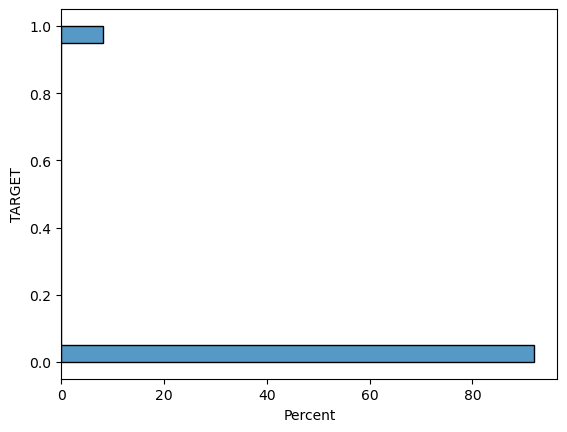

92 of loans were paid by clients


In [72]:
display(pd.concat([app_train['TARGET'].value_counts(),round(100*app_train['TARGET'].value_counts()/app_train['TARGET'].count())], axis=1).set_axis(['Counts', 'Percentage'], axis='columns'))
sns.histplot(y=app_train['TARGET'], legend=True, stat="percent")
plt.show()
plt.close()

## Get number of paid loans - i.e. Tagret == 0
print("{} of loans were paid by clients".format(round((100*app_train['TARGET'].value_counts()/app_train['TARGET'].count()).loc[0])))

In [10]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [11]:
app_train.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [86]:
## Get number of duplicated rows
## Get number of duplicated rows - without target
## Cheking for rows overlap for different TARGET values

print("number of duplicated rows is {} and \nnumber of duplicated rows without TARGET is {}".format(app_train.duplicated(keep=False).sum(), app_train.drop(["TARGET"], axis=1).duplicated(keep=False).sum()))

number of duplicated rows is 0 and 
number of duplicated rows without TARGET is 0


In [12]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

<Axes: title={'center': 'Data types'}>

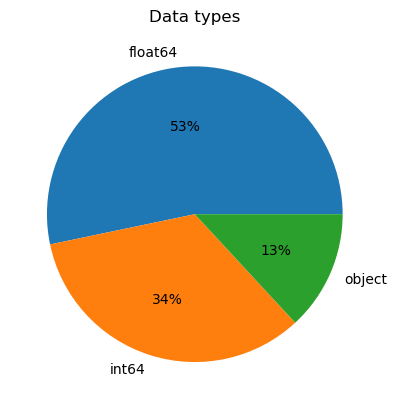

In [71]:
app_train.dtypes.value_counts().plot(kind='pie', autopct='%1.0f%%', ylabel="", title="Data types")

In [13]:
print("Number of nominal variables identified by dython",len(identify_nominal_columns(app_train)))
print(identify_nominal_columns(app_train))

Number of nominal variables identified by dython 16
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [14]:
# how many missing values does the training dataset contain
from functions import get_missing_values_summary_dataframe
get_missing_values_summary_dataframe(app_train)

,Column,Sum of Missing Values,Percentage of Missing Values
41,COMMONAREA_MEDI,214865,69.872297
13,COMMONAREA_AVG,214865,69.872297
27,COMMONAREA_MODE,214865,69.872297
49,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
35,NONLIVINGAPARTMENTS_MODE,213514,69.432963
...,...,...,...
7,EXT_SOURCE_2,660,0.214626
1,AMT_GOODS_PRICE,278,0.090403
0,AMT_ANNUITY,12,0.003902
5,CNT_FAM_MEMBERS,2,0.000650


### Explore Numerical Data - Training Data

In [15]:
numerical_x = app_train.select_dtypes(include=['number']).columns.values
app_train[numerical_x].describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.00000,189145.500000,278202.00000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.00000,0.000000,0.00000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.00000,0.000000,0.00000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.00000,112500.000000,147150.00000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.00000,270000.000000,513531.00000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1615.50000,16524.000000,24903.00000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,40500.00000,238500.000000,450000.00000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,0.00029,0.010006,0.01885,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.00000,-19682.000000,-15750.00000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.00000,-2760.000000,-1213.00000,-289.000000,3.652430e+05


In [16]:
# Adjust indeces to screen for better visibility
(app_train[numerical_x].describe().T).iloc[9:30]

,count,mean,std,min,25%,50%,75%,max
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.000000,-2760.000000,-1213.000000,-289.000000,365243.000000
DAYS_REGISTRATION,307511.0,-4986.120328,3522.886321,-24672.000000,-7479.500000,-4504.000000,-2010.000000,0.000000
DAYS_ID_PUBLISH,307511.0,-2994.202373,1509.450419,-7197.000000,-4299.000000,-3254.000000,-1720.000000,0.000000
OWN_CAR_AGE,104582.0,12.061091,11.944812,0.000000,5.000000,9.000000,15.000000,91.000000
FLAG_MOBIL,307511.0,0.999997,0.001803,0.000000,1.000000,1.000000,1.000000,1.000000
FLAG_EMP_PHONE,307511.0,0.819889,0.384280,0.000000,1.000000,1.000000,1.000000,1.000000
FLAG_WORK_PHONE,307511.0,0.199368,0.399526,0.000000,0.000000,0.000000,0.000000,1.000000
FLAG_CONT_MOBILE,307511.0,0.998133,0.043164,0.000000,1.000000,1.000000,1.000000,1.000000
FLAG_PHONE,307511.0,0.281066,0.449521,0.000000,0.000000,0.000000,1.000000,1.000000
FLAG_EMAIL,307511.0,0.056720,0.231307,0.000000,0.000000,0.000000,0.000000,1.000000


### Explore Categorical Data - Training Data

In [17]:
# How many categories are there in each categorical variable of the training dataset?
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [18]:
categorical_x = list(app_train.select_dtypes('object').columns)
chi2_contingency_df = []
for xx in list(product(categorical_x, categorical_x, repeat=1)) : 
    if xx[0] != xx[1]:
        chi2_contingency_df.append((xx[0], 
                                   xx[1], 
                                   list(chi2_contingency(pd.crosstab(app_train[xx[0]], app_train[xx[1]])))[1]
                                  ))


# the hypothesis with chi2 is that the two columns have no relation.
# if the pvalue is close to zero, that means that the hypothesis can be rejected.
# in the following dataframe, we highlight the relations for which the hypothesis can be rejected.
pd.DataFrame(chi2_contingency_df, columns=['categorical_x_1', 'categorical_x_2', 'pvalue'])\
    .pivot(index="categorical_x_1", columns="categorical_x_2", values="pvalue")\
    .style.apply(lambda x: ["background: gray" if value <= 0.05 else "" for value in x ], axis=1)

categorical_x_2,CODE_GENDER,EMERGENCYSTATE_MODE,FLAG_OWN_CAR,FLAG_OWN_REALTY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START
categorical_x_1,,,,,,,,,,,,,,,,
CODE_GENDER,nan,0.319866,0.000000,0.000000,0.060623,0.027805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,0.002504
EMERGENCYSTATE_MODE,0.319866,nan,0.010332,0.000000,0.000000,0.000000,0.171749,0.000000,0.115558,0.000000,0.000000,0.366045,0.000000,0.000048,0.000000,0.051874
FLAG_OWN_CAR,0.000000,0.010332,nan,0.119278,0.000924,0.000251,0.026160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028980
FLAG_OWN_REALTY,0.000000,0.000000,0.119278,nan,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FONDKAPREMONT_MODE,0.060623,0.000000,0.000924,0.000009,nan,0.000000,0.084892,0.000000,0.037412,0.000000,0.000000,0.083560,0.000000,0.000000,0.000000,0.001799
HOUSETYPE_MODE,0.027805,0.000000,0.000251,0.000000,0.000000,nan,0.413730,0.000000,0.000613,0.000000,0.000000,0.391300,0.000000,0.000000,0.000000,0.656525
NAME_CONTRACT_TYPE,0.000000,0.171749,0.026160,0.000000,0.084892,0.413730,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000073,0.000000
NAME_EDUCATION_TYPE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000048
NAME_FAMILY_STATUS,0.000000,0.115558,0.000000,0.000000,0.037412,0.000613,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000601


- It looks like lots of categorical variables are correlated (pairwise)
- This might cause a problem later on, because it would be hard to guess how each variable is impacting predictions


## Getting familiar with Testing data

In [19]:
app_test = pd.read_csv('../work/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'Data types'}>

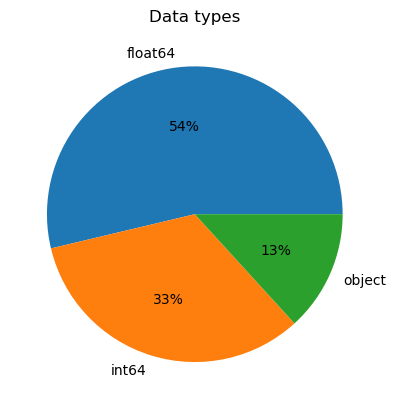

In [21]:
app_test.dtypes.value_counts().plot(kind='pie', autopct='%1.0f%%', ylabel="", title="Data types")